In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

### 1.数据总体观察

In [2]:
#观察数据
data = pd.read_csv("D:/project/credit Card Detection/dataset/creditcard.csv")
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
data.info()
# 没有object对象

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

C:\Users\cm400\AppData\Local\Temp\ipykernel_16368\3116070103.py:3: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  count_classes = pd.value_counts(data['Class'], sort = True).sort_index()


Text(0, 0.5, 'Frequency')

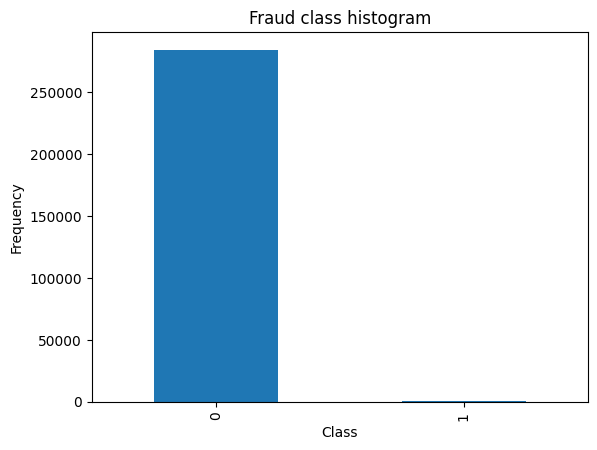

In [4]:
#Class为 0 —— 正常交易    Class为 1 —— 欺诈行为
#建立柱形图
count_classes = pd.value_counts(data['Class'], sort = True).sort_index()
count_classes.plot(kind = 'bar')
plt.title("Fraud class histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")

数据极度不平衡

### 2.数据映射

__对于imbalanced dataset，通常可以从数据和算法两个角度思考，一是boost类增加权重的算法，另一是smote或是under_sample__

In [5]:
"""Borderline-SMOTE: A New Over-Sampling Method in Imbalanced Data Sets Learning""" 
# 复现了上述论文的部分代码，代码风格参考了smote的源码和base基类的源码

import numbers
import warnings
import numpy as np
from scipy import sparse
from sklearn.base import clone
from sklearn.utils import _safe_indexing, check_random_state

from sklearn.preprocessing import label_binarize
from sklearn.utils.fixes import parse_version
from sklearn.utils.multiclass import check_classification_targets

from imblearn.utils import check_sampling_strategy, check_target_type
from imblearn.utils._param_validation import validate_parameter_constraints
from imblearn.utils._validation import ArraysTransformer

from imblearn.utils import Substitution , check_neighbors_object
from imblearn.utils._docstring import _n_jobs_docstring, _random_state_docstring
from imblearn.utils._param_validation import HasMethods, Interval, StrOptions
from imblearn.over_sampling.base import BaseOverSampler
from imblearn.over_sampling._smote.base import BaseSMOTE

@Substitution(
    sampling_strategy=BaseOverSampler._sampling_strategy_docstring,
    n_jobs=_n_jobs_docstring,
    random_state=_random_state_docstring,
)
class BorderlineSMOTE(BaseSMOTE):
    _parameter_constraints: dict = {
        **BaseSMOTE._parameter_constraints,
        "m_neighbors": [
            Interval(numbers.Integral, 1, None, closed="left"),
            HasMethods(["kneighbors", "kneighbors_graph"]),
        ],
        "kind": [StrOptions({"borderline-1", "borderline-2"})],
    }

    def __init__(
        self,
        *,
        sampling_strategy="auto",
        random_state=None,
        k_neighbors=5,
        n_jobs=None,
        m_neighbors=10,
        kind="borderline-1",
    ):
        super().__init__(
            sampling_strategy=sampling_strategy,
            random_state=random_state,
            k_neighbors=k_neighbors,
            n_jobs=n_jobs,
        )
        self.m_neighbors = m_neighbors
        self.kind = kind

    def _validate_estimator(self):
        super()._validate_estimator()
        self.nn_m_ = check_neighbors_object(
            "m_neighbors", self.m_neighbors, additional_neighbor=1
        )

    def _fit_resample(self, X, y):
        # FIXME: to be removed in 0.12
        if self.n_jobs is not None:
            warnings.warn(
                FutureWarning,
            )

        self._validate_estimator()

        X_resampled = X.copy()
        y_resampled = y.copy()

        self.in_danger_indices = {}
        for class_sample, n_samples in self.sampling_strategy_.items():
            if n_samples == 0:
                continue
            target_class_indices = np.flatnonzero(y == class_sample)
            X_class = _safe_indexing(X, target_class_indices)

            self.nn_m_.fit(X)
            mask_danger = self._in_danger_noise(
                self.nn_m_, X_class, class_sample, y, kind="danger"
            )
            if not any(mask_danger):
                continue
            X_danger = _safe_indexing(X_class, mask_danger)
            self.in_danger_indices[class_sample] = target_class_indices[mask_danger]

            if self.kind == "borderline-1":
                X_to_sample_from = X_class  # consider the positive class only
                y_to_check_neighbors = None
            else:  # self.kind == "borderline-2"
                X_to_sample_from = X  # consider the whole dataset
                y_to_check_neighbors = y

            self.nn_k_.fit(X_to_sample_from)
            nns = self.nn_k_.kneighbors(X_danger, return_distance=False)[:, 1:]
            X_new, y_new = self._make_samples(
                X_danger,
                y.dtype,
                class_sample,
                X_to_sample_from,
                nns,
                n_samples,
                y=y_to_check_neighbors,
            )
            if sparse.issparse(X_new):
                X_resampled = sparse.vstack([X_resampled, X_new])
            else:
                X_resampled = np.vstack((X_resampled, X_new))
            y_resampled = np.hstack((y_resampled, y_new))

        return X_resampled, y_resampled



#### 对 Time、Amount 特征归一化

In [6]:
from sklearn.preprocessing import StandardScaler

# fit_transform 拟合数据，然后对其进行转换
data['nowAmount'] = StandardScaler().fit_transform(
    data['Amount'].values.reshape(-1,1))  # data['Amount']是Series类型，需要转化成numpy的ndarray

data['nowTime'] = StandardScaler().fit_transform(
    data['Time'].values.reshape(-1,1)) 
# 删除原始的数据列
data.drop(['Amount', 'Time'], axis=1, inplace=True) 

data['nowAmount']
data['nowTime']

0        -1.996583
1        -1.996583
2        -1.996562
3        -1.996562
4        -1.996541
            ...   
284802    1.641931
284803    1.641952
284804    1.641974
284805    1.641974
284806    1.642058
Name: nowTime, Length: 284807, dtype: float64

#### 数据下采样

In [7]:
# 切分特征值和标签值
X = data.loc[:, data.columns != 'Class']  # 取除Class列以外的所有列
y = data.loc[:, data.columns == 'Class']  # 只取Class列

# fraud 欺诈 Class==1 / normal 正常 Class==0 / indices索引
from imblearn.over_sampling import BorderlineSMOTE
Bsm = BorderlineSMOTE()
X_resample , y_resample = Bsm.fit_resample(X , y)

number_records_fraud = len(data[data['Class'] == 1])  # 欺诈样本的数量 492

# 取欺诈样本的索引
fraud_indices = np.array(data[data['Class'] == 1].index)  # data['Class'] == 1 会返回一串 Ture False 字符串列表，再把这个当作索引
# 取正常样本的索引
normal_indices = data[data['Class'] == 0].index

# 下采样，使得两个样本同样少
#print(normal_indices)
#print(number_records_fraud)
# 随机生成正常样本的索引 / 在normal_indices中选number_records_fraud个 / 这里normal_indices远大于number_records_fraud / replace 所取样本是否能有重复值
random_normal_indices = np.random.choice(a=normal_indices, size=number_records_fraud, replace=False)
random_normal_indices = np.array(random_normal_indices)

# 将class=1和class=0 的选出来的索引值进行合并 此时这两个样本的数量是一样的
under_sample_indices = np.concatenate([fraud_indices, random_normal_indices])

under_sample_data = data.iloc[under_sample_indices, :]  # 取对应索引的数据

# 切分特征值和标签值
X_under_sample = under_sample_data.loc[:, under_sample_data.columns != 'Class']
y_under_sample = under_sample_data.loc[:, under_sample_data.columns == 'Class']

# Showing ratio
print("Percentage of normal transactions: ",
      len(under_sample_data[under_sample_data.Class == 0]) / len(under_sample_data))
print("Percentage of fraud transactions: ",
      len(under_sample_data[under_sample_data.Class == 1]) / len(under_sample_data))
print("Total number of transactions in resampled data: ", len(under_sample_data))


Percentage of normal transactions:  0.5
Percentage of fraud transactions:  0.5
Total number of transactions in resampled data:  984


In [8]:
from sklearn.model_selection import train_test_split

# 原始样本用于测试
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
#随机切分，random_state=0类似设置随机数种子，test_size就是测试集比例，我这里设置为0.3即0.7训练集，0.3测试集

print("原始样本训练集:", len(X_train))
print("原始样本测试集: ", len(X_test))
print("原始样本总数:", len(X_train) + len(X_test))

# 下采样样本用于训练
# 类型还是DataFrame
X_train_undersample, X_test_undersample, y_train_undersample, y_test_undersample = train_test_split(X_under_sample,y_under_sample,test_size=0.3,random_state=0)

print("下采样样本训练集: ", len(X_train_undersample))
print("下采样样本测试集: ", len(X_test_undersample))
print("下采样样本总数:", len(X_train_undersample) + len(X_test_undersample))

原始样本训练集: 199364
原始样本测试集:  85443
原始样本总数: 284807
下采样样本训练集:  688
下采样样本测试集:  296
下采样样本总数: 984


#### 相关性分析

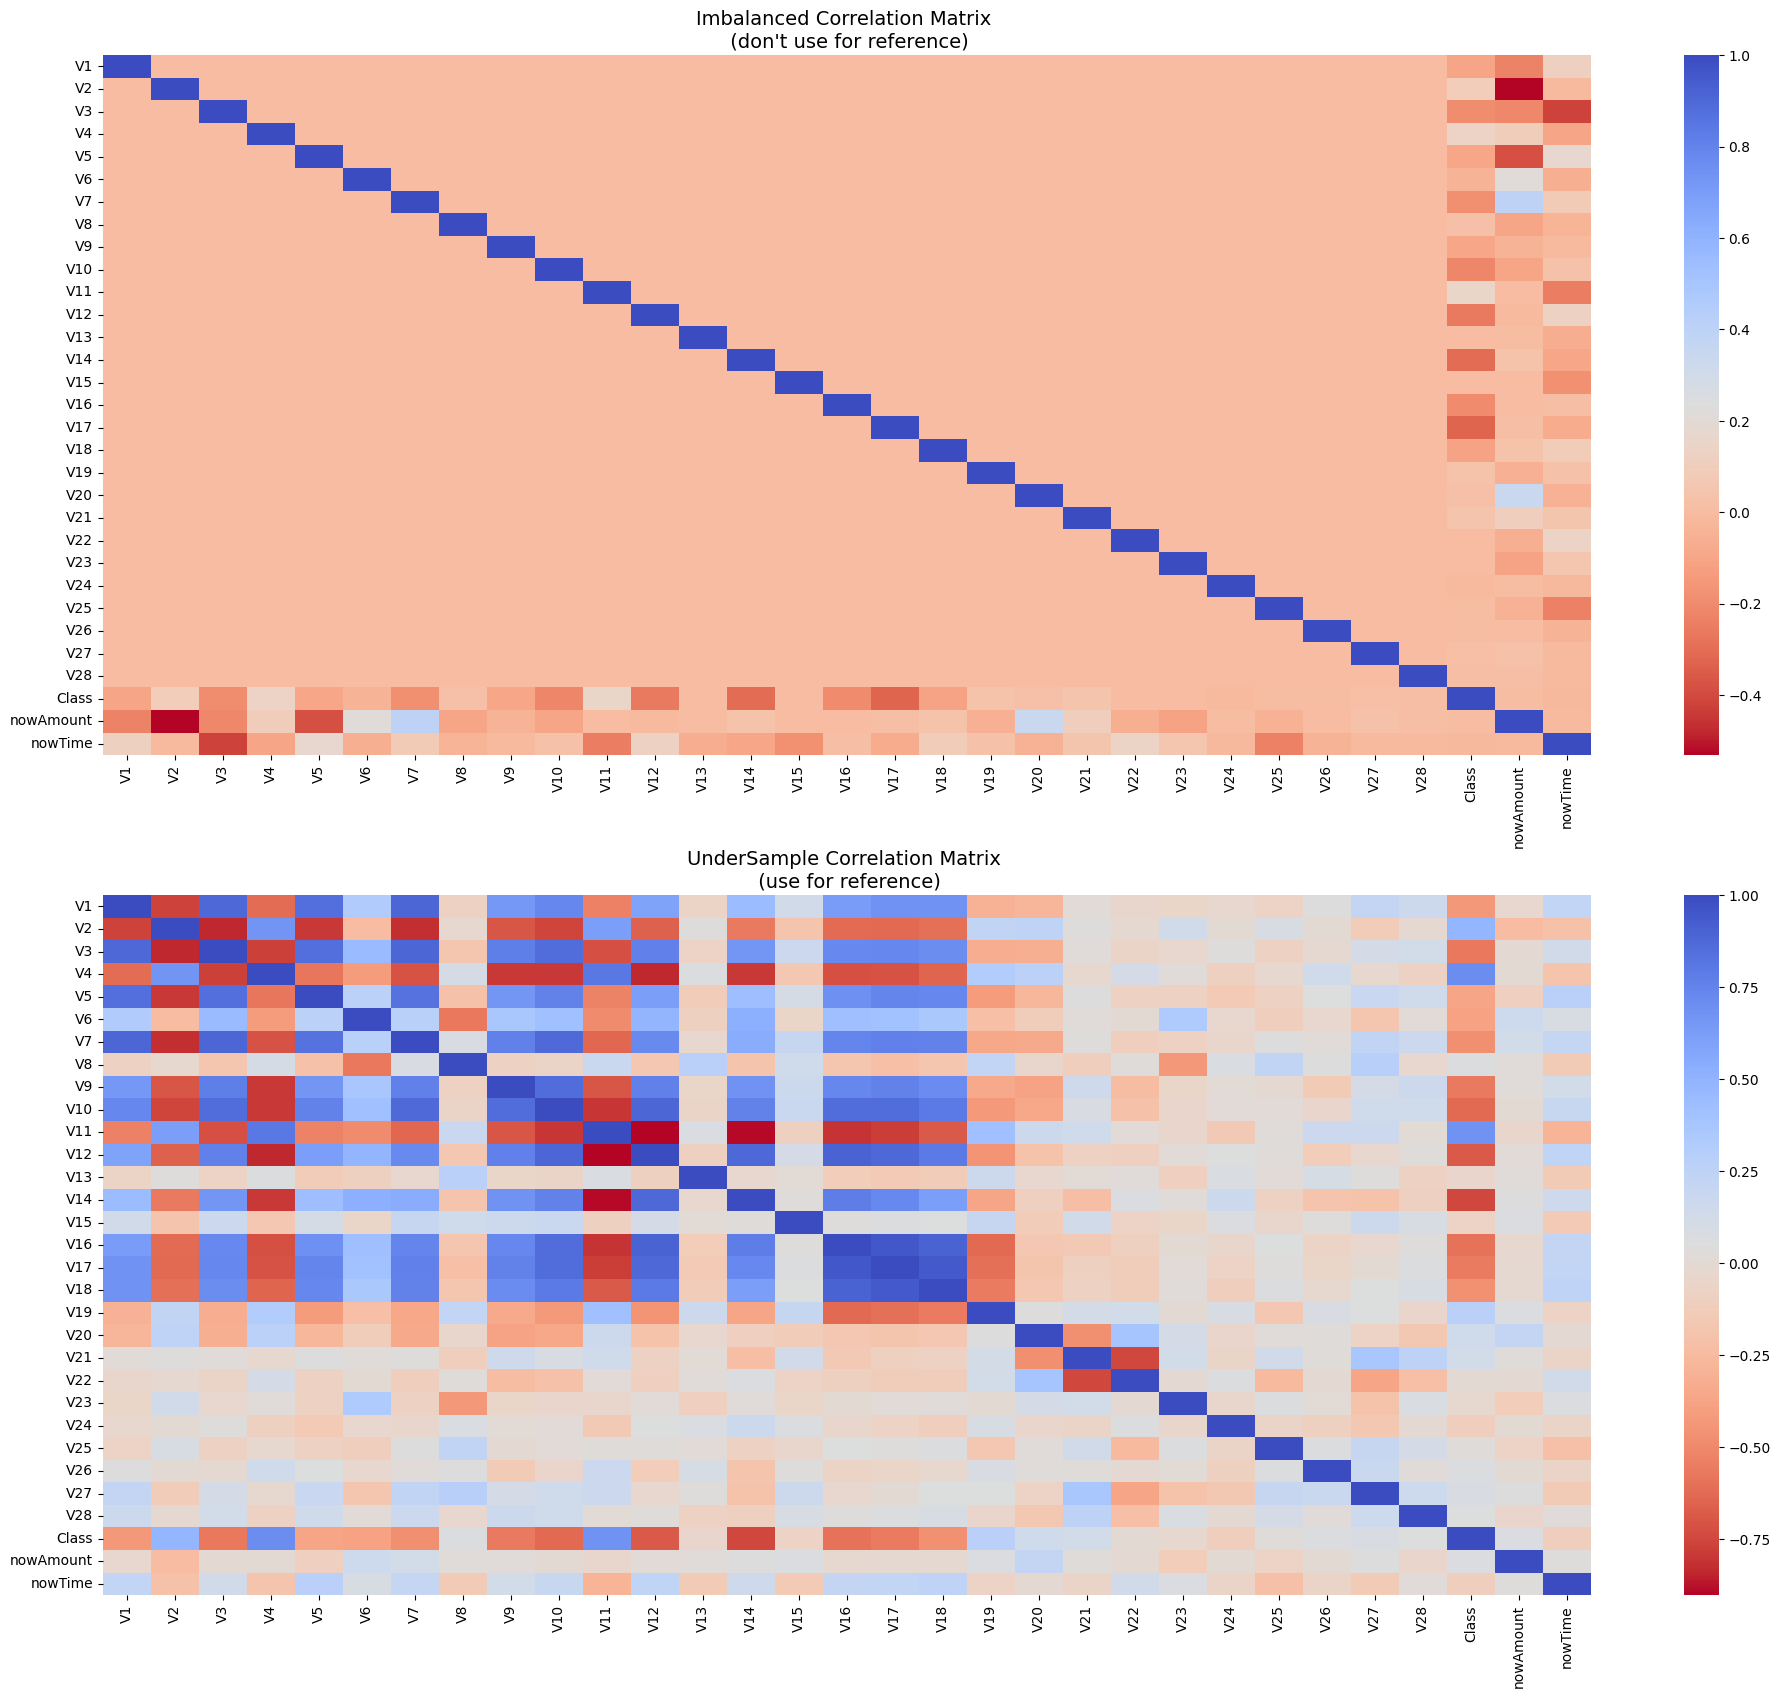

In [9]:
import seaborn as sns

# 绘制相关矩阵
# 用于了解与欺诈交易具有高度相关性的特征
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24,20))

#整个数据样本的相关矩阵
corr = data.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Imbalanced Correlation Matrix \n (don't use for reference)", fontsize=14)

#下采样样本的相关矩阵
under_sample_corr = under_sample_data.corr()
sns.heatmap(under_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax2)
ax2.set_title('UnderSample Correlation Matrix \n (use for reference)', fontsize=14)
plt.show()

由相关矩阵可知：
负相关：V17，V14，V12和V10呈负相关。
正相关：V2，V4，V11和V19呈正相关。
使用箱线图进行来了解这些特征在信用卡欺诈交易中的分布。
注：在数据分析时使用下采样样本的相关矩阵，否则相关矩阵将受到数据类别高度不平衡的影响。这是由于原始数据集中高度不平衡造成的。

C:\Users\cm400\AppData\Local\Temp\ipykernel_16368\4077237007.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Class", y="V17", data=under_sample_data, palette=colors, ax=axes[0])
C:\Users\cm400\AppData\Local\Temp\ipykernel_16368\4077237007.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Class", y="V14", data=under_sample_data, palette=colors, ax=axes[1])
C:\Users\cm400\AppData\Local\Temp\ipykernel_16368\4077237007.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Class", y="V12", data=under_sample_data, palette=colors, ax=

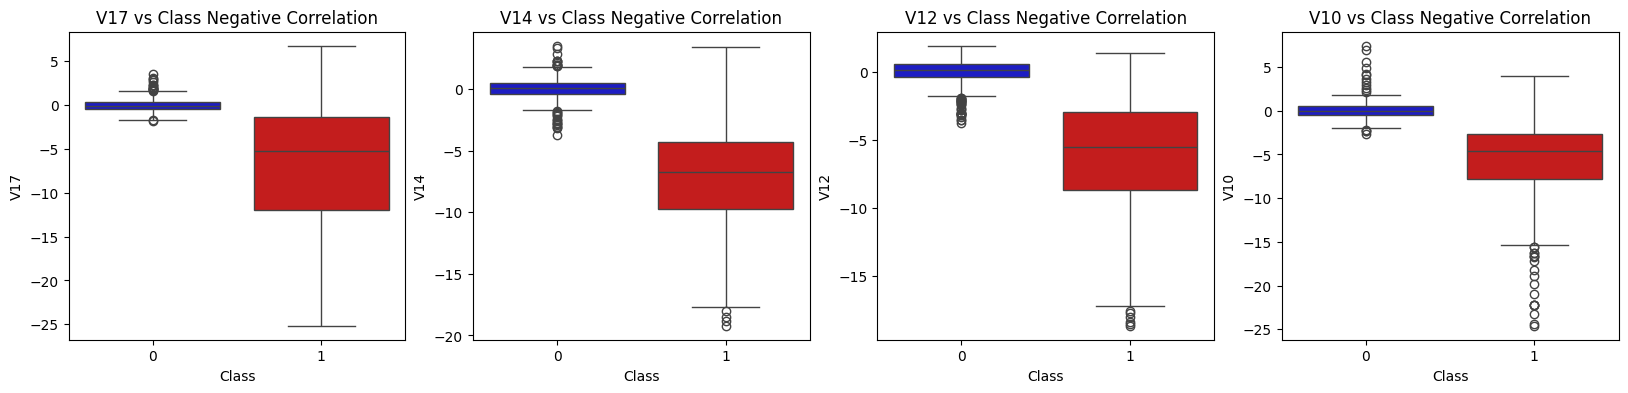

In [10]:
#绘制负相关特征的箱线图
colors = ["#0101DF", "#DF0101"]

f, axes = plt.subplots(ncols=4, figsize=(20,4))

sns.boxplot(x="Class", y="V17", data=under_sample_data, palette=colors, ax=axes[0])
axes[0].set_title('V17 vs Class Negative Correlation')

sns.boxplot(x="Class", y="V14", data=under_sample_data, palette=colors, ax=axes[1])
axes[1].set_title('V14 vs Class Negative Correlation')


sns.boxplot(x="Class", y="V12", data=under_sample_data, palette=colors, ax=axes[2])
axes[2].set_title('V12 vs Class Negative Correlation')


sns.boxplot(x="Class", y="V10", data=under_sample_data, palette=colors, ax=axes[3])
axes[3].set_title('V10 vs Class Negative Correlation')

plt.show()

C:\Users\cm400\AppData\Local\Temp\ipykernel_16368\1350721791.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Class", y="V11", data=under_sample_data, palette=colors, ax=axes[0])
C:\Users\cm400\AppData\Local\Temp\ipykernel_16368\1350721791.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Class", y="V4", data=under_sample_data, palette=colors, ax=axes[1])
C:\Users\cm400\AppData\Local\Temp\ipykernel_16368\1350721791.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Class", y="V2", data=under_sample_data, palette=colors, ax=ax

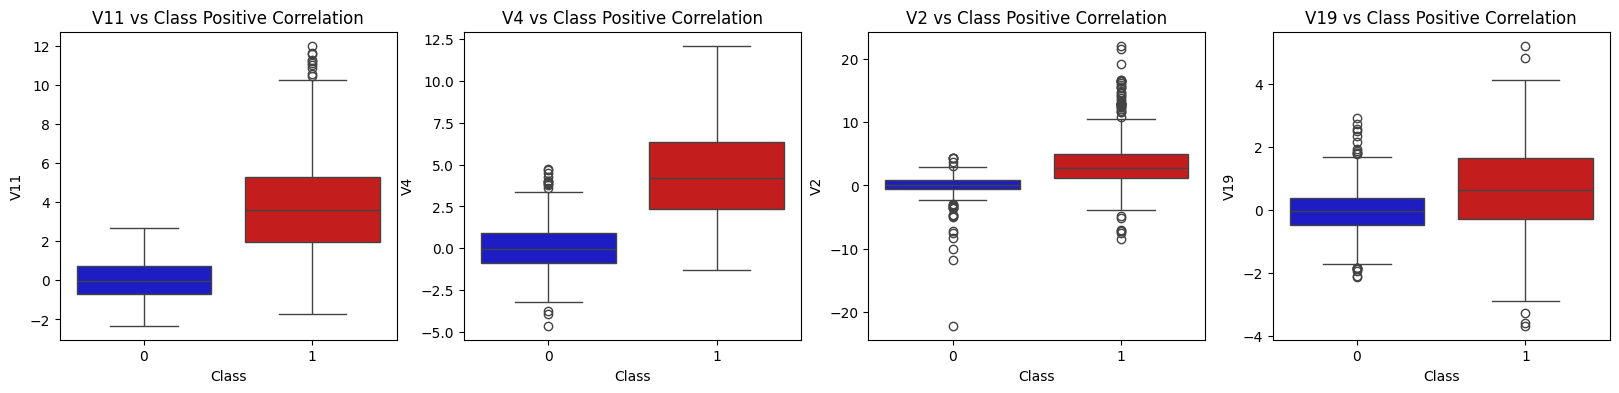

In [11]:
#绘制正相关矩阵的箱线图
f, axes = plt.subplots(ncols=4, figsize=(20,4))

sns.boxplot(x="Class", y="V11", data=under_sample_data, palette=colors, ax=axes[0])
axes[0].set_title('V11 vs Class Positive Correlation')

sns.boxplot(x="Class", y="V4", data=under_sample_data, palette=colors, ax=axes[1])
axes[1].set_title('V4 vs Class Positive Correlation')


sns.boxplot(x="Class", y="V2", data=under_sample_data, palette=colors, ax=axes[2])
axes[2].set_title('V2 vs Class Positive Correlation')


sns.boxplot(x="Class", y="V19", data=under_sample_data, palette=colors, ax=axes[3])
axes[3].set_title('V19 vs Class Positive Correlation')

plt.show()

异常检测：剔除异常值
使用IQR方法标记异常值，异常值去除权值为1.5。删除标记的异常值后，通过箱线图可视化地表示处理后的数据。

#### 主要特征可视化分布

C:\Users\cm400\AppData\Local\Temp\ipykernel_16368\2336516878.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(v14_fraud_dist,ax=ax1, fit=norm, color='#FB8861')
C:\Users\cm400\AppData\Local\Temp\ipykernel_16368\2336516878.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(v12_fraud_dist,ax=a

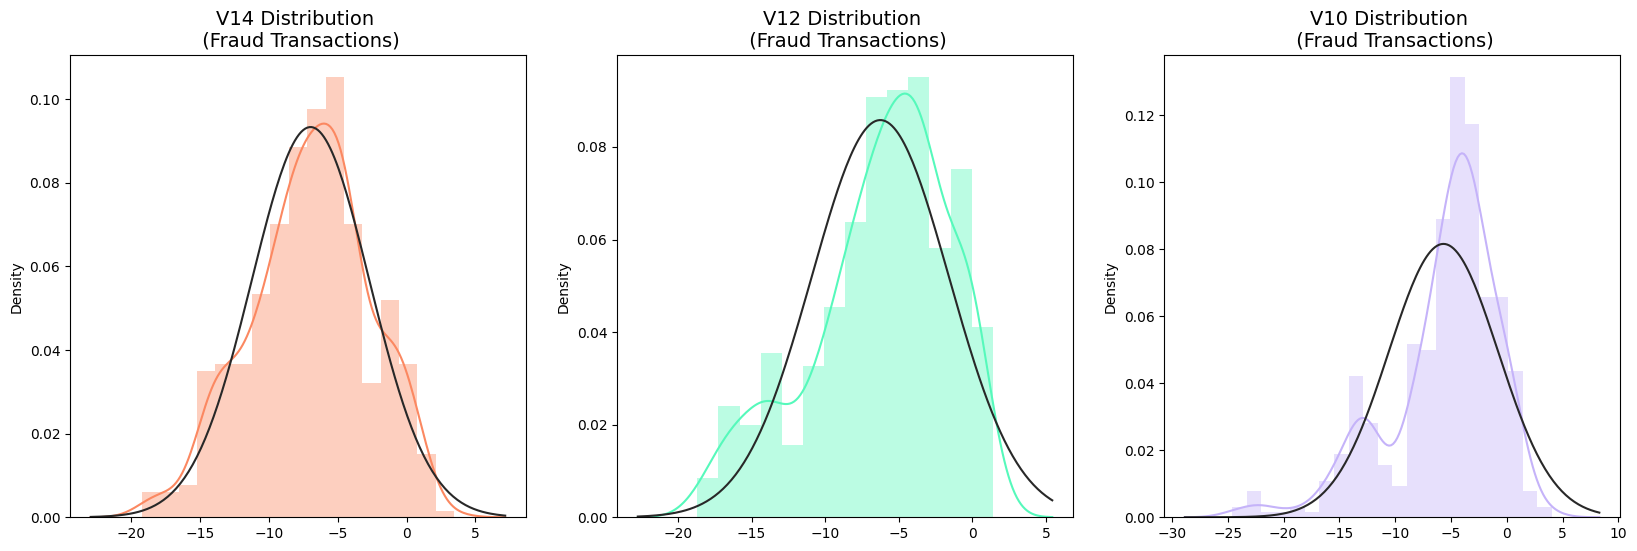

In [12]:
from scipy.stats import norm

#负相关
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20, 6))

v14_fraud_dist = under_sample_data['V14'].loc[under_sample_data['Class'] == 1].values
sns.distplot(v14_fraud_dist,ax=ax1, fit=norm, color='#FB8861')
ax1.set_title('V14 Distribution \n (Fraud Transactions)', fontsize=14)

v12_fraud_dist = under_sample_data['V12'].loc[under_sample_data['Class'] == 1].values
sns.distplot(v12_fraud_dist,ax=ax2, fit=norm, color='#56F9BB')
ax2.set_title('V12 Distribution \n (Fraud Transactions)', fontsize=14)


v10_fraud_dist = under_sample_data['V10'].loc[under_sample_data['Class'] == 1].values
sns.distplot(v10_fraud_dist,ax=ax3, fit=norm, color='#C5B3F9')
ax3.set_title('V10 Distribution \n (Fraud Transactions)', fontsize=14)


plt.show()

与V12和V10相比，V14是唯一具有高斯分布的特征。

C:\Users\cm400\AppData\Local\Temp\ipykernel_16368\3858329043.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(v4_fraud_dist,ax=ax1, fit=norm, color='#FB8861')
C:\Users\cm400\AppData\Local\Temp\ipykernel_16368\3858329043.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(v2_fraud_dist,ax=ax2,

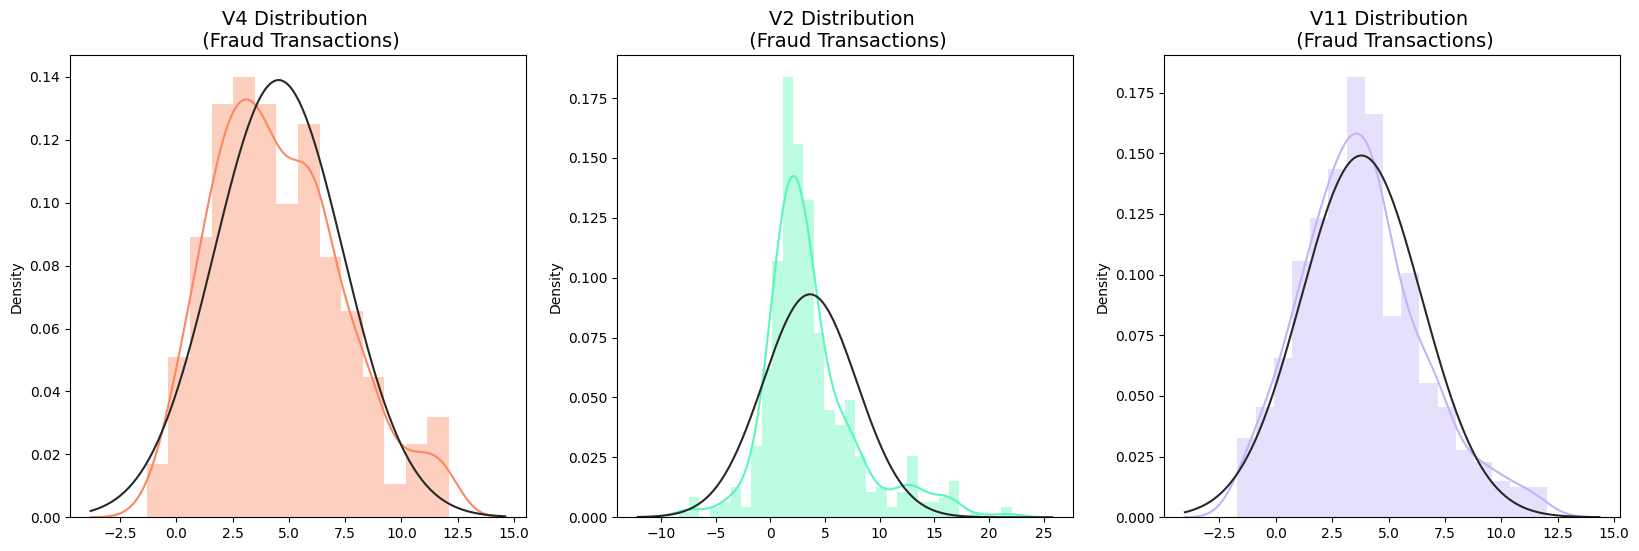

In [13]:
#正相关
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20, 6))

v4_fraud_dist = under_sample_data['V4'].loc[under_sample_data['Class'] == 1].values
sns.distplot(v4_fraud_dist,ax=ax1, fit=norm, color='#FB8861')
ax1.set_title('V4 Distribution \n (Fraud Transactions)', fontsize=14)

v2_fraud_dist = under_sample_data['V2'].loc[under_sample_data['Class'] == 1].values
sns.distplot(v2_fraud_dist,ax=ax2, fit=norm, color='#56F9BB')
ax2.set_title('V2 Distribution \n (Fraud Transactions)', fontsize=14)


v11_fraud_dist = under_sample_data['V11'].loc[under_sample_data['Class'] == 1].values
sns.distplot(v11_fraud_dist,ax=ax3, fit=norm, color='#C5B3F9')
ax3.set_title('V11 Distribution \n (Fraud Transactions)', fontsize=14)


plt.show()

#### 异常值处理

与V2和V4相比，V11是唯一具有高斯分布的特征。

In [14]:
#使用IQR方法标记异常值，异常值去除权值为1.5。去除异常值。
#V14去除异常值
v14_fraud = under_sample_data['V14'].loc[under_sample_data['Class'] == 1].values
q25, q75 = np.percentile(v14_fraud, 25), np.percentile(v14_fraud, 75)
print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
v14_iqr = q75 - q25
print('iqr: {}'.format(v14_iqr))

v14_cut_off = v14_iqr * 1.5
v14_lower, v14_upper = q25 - v14_cut_off, q75 + v14_cut_off
print('Cut Off: {}'.format(v14_cut_off))
print('V14 Lower: {}'.format(v14_lower))
print('V14 Upper: {}'.format(v14_upper))

outliers = [x for x in v14_fraud if x < v14_lower or x > v14_upper]
print('Feature V14 Outliers for Fraud Cases: {}'.format(len(outliers)))
print('V14 outliers:{}'.format(outliers))

under_sample_data = under_sample_data.drop(under_sample_data[(under_sample_data['V14'] > v14_upper) | (under_sample_data['V14'] < v14_lower)].index)
print('----' * 44)

#V12去除异常值
v12_fraud = under_sample_data['V12'].loc[under_sample_data['Class'] == 1].values
q25, q75 = np.percentile(v12_fraud, 25), np.percentile(v12_fraud, 75)
print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
v12_iqr = q75 - q25
print('iqr: {}'.format(v12_iqr))

v12_cut_off = v12_iqr * 1.5
v12_lower, v12_upper = q25 - v12_cut_off, q75 + v12_cut_off
print('Cut Off: {}'.format(v12_cut_off))
print('V12 Lower: {}'.format(v12_lower))
print('V12 Upper: {}'.format(v12_upper))

outliers = [x for x in v12_fraud if x < v12_lower or x > v12_upper]
print('Feature V12 Outliers for Fraud Cases: {}'.format(len(outliers)))
print('V10 outliers:{}'.format(outliers))

under_sample_data = under_sample_data.drop(under_sample_data[(under_sample_data['V12'] > v12_upper) | (under_sample_data['V12'] < v12_lower)].index)
print('----' * 44)

#V10去除异常值
v10_fraud = under_sample_data['V10'].loc[under_sample_data['Class'] == 1].values
q25, q75 = np.percentile(v10_fraud, 25), np.percentile(v10_fraud, 75)
v10_iqr = q75 - q25

v10_cut_off = v10_iqr * 1.5
v10_lower, v10_upper = q25 - v10_cut_off, q75 + v10_cut_off
print('V10 Lower: {}'.format(v10_lower))
print('V10 Upper: {}'.format(v10_upper))
outliers = [x for x in v10_fraud if x < v10_lower or x > v10_upper]
print('V10 outliers: {}'.format(outliers))
print('Feature V10 Outliers for Fraud Cases: {}'.format(len(outliers)))

#V4去除异常值
v4_fraud = under_sample_data['V4'].loc[under_sample_data['Class'] == 1].values
q25, q75 = np.percentile(v4_fraud, 25), np.percentile(v4_fraud, 75)
print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
v4_iqr = q75 - q25
print('iqr: {}'.format(v4_iqr))

v4_cut_off = v4_iqr * 1.5
v4_lower, v4_upper = q25 - v4_cut_off, q75 + v4_cut_off
print('Cut Off: {}'.format(v4_cut_off))
print('V4 Lower: {}'.format(v4_lower))
print('V4 Upper: {}'.format(v4_upper))

outliers = [x for x in v4_fraud if x < v4_lower or x > v4_upper]
print('Feature V4 Outliers for Fraud Cases: {}'.format(len(outliers)))
print('V4 outliers:{}'.format(outliers))

under_sample_data = under_sample_data.drop(under_sample_data[(under_sample_data['V4'] > v4_upper) | (under_sample_data['V4'] < v4_lower)].index)
print('----' * 44)

#V12去除异常值
v2_fraud = under_sample_data['V2'].loc[under_sample_data['Class'] == 1].values
q25, q75 = np.percentile(v2_fraud, 25), np.percentile(v2_fraud, 75)
print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
v2_iqr = q75 - q25
print('iqr: {}'.format(v2_iqr))

v2_cut_off = v2_iqr * 1.5
v2_lower, v2_upper = q25 - v2_cut_off, q75 + v2_cut_off
print('Cut Off: {}'.format(v2_cut_off))
print('V2 Lower: {}'.format(v2_lower))
print('V2 Upper: {}'.format(v2_upper))

outliers = [x for x in v2_fraud if x < v2_lower or x > v2_upper]
print('Feature V2 Outliers for Fraud Cases: {}'.format(len(outliers)))
print('V2 outliers:{}'.format(outliers))

under_sample_data = under_sample_data.drop(under_sample_data[(under_sample_data['V2'] > v2_upper) | (under_sample_data['V2'] < v2_lower)].index)
print('----' * 44)

#V10去除异常值
v11_fraud = under_sample_data['V11'].loc[under_sample_data['Class'] == 1].values
q25, q75 = np.percentile(v11_fraud, 25), np.percentile(v11_fraud, 75)
v11_iqr = q75 - q25

v11_cut_off = v11_iqr * 1.5
v11_lower, v11_upper = q25 - v11_cut_off, q75 + v11_cut_off
print('V11 Lower: {}'.format(v11_lower))
print('V11 Upper: {}'.format(v11_upper))
outliers = [x for x in v11_fraud if x < v11_lower or x > v11_upper]
print('V11 outliers: {}'.format(outliers))
print('Feature V11 Outliers for Fraud Cases: {}'.format(len(outliers)))
under_sample_data = under_sample_data.drop(under_sample_data[(under_sample_data['V11'] > v11_upper) | (under_sample_data['V11'] < v11_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(under_sample_data)))

Quartile 25: -9.692722964972386 | Quartile 75: -4.282820849486865
iqr: 5.409902115485521
Cut Off: 8.114853173228282
V14 Lower: -17.807576138200666
V14 Upper: 3.8320323237414167
Feature V14 Outliers for Fraud Cases: 4
V14 outliers:[np.float64(-19.2143254902614), np.float64(-18.8220867423816), np.float64(-18.4937733551053), np.float64(-18.0499976898594)]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Quartile 25: -8.67303320439115 | Quartile 75: -2.893030568676315
iqr: 5.780002635714835
Cut Off: 8.670003953572252
V12 Lower: -17.3430371579634
V12 Upper: 5.776973384895937
Feature V12 Outliers for Fraud Cases: 4
V10 outliers:[np.float64(-18.0475965708216), np.float64(-18.6837146333443), np.float64(-18.5536970096458), np.float64(-18.4311310279993)]
---------------------------------------------------------------------------------------------------------------------

C:\Users\cm400\AppData\Local\Temp\ipykernel_16368\1718182429.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Class", y="V14", data=under_sample_data,ax=ax1, palette=colors)
C:\Users\cm400\AppData\Local\Temp\ipykernel_16368\1718182429.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Class", y="V12", data=under_sample_data, ax=ax2, palette=colors)
C:\Users\cm400\AppData\Local\Temp\ipykernel_16368\1718182429.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Class", y="V10", data=under_sample_data, ax=ax3, palette=colors)


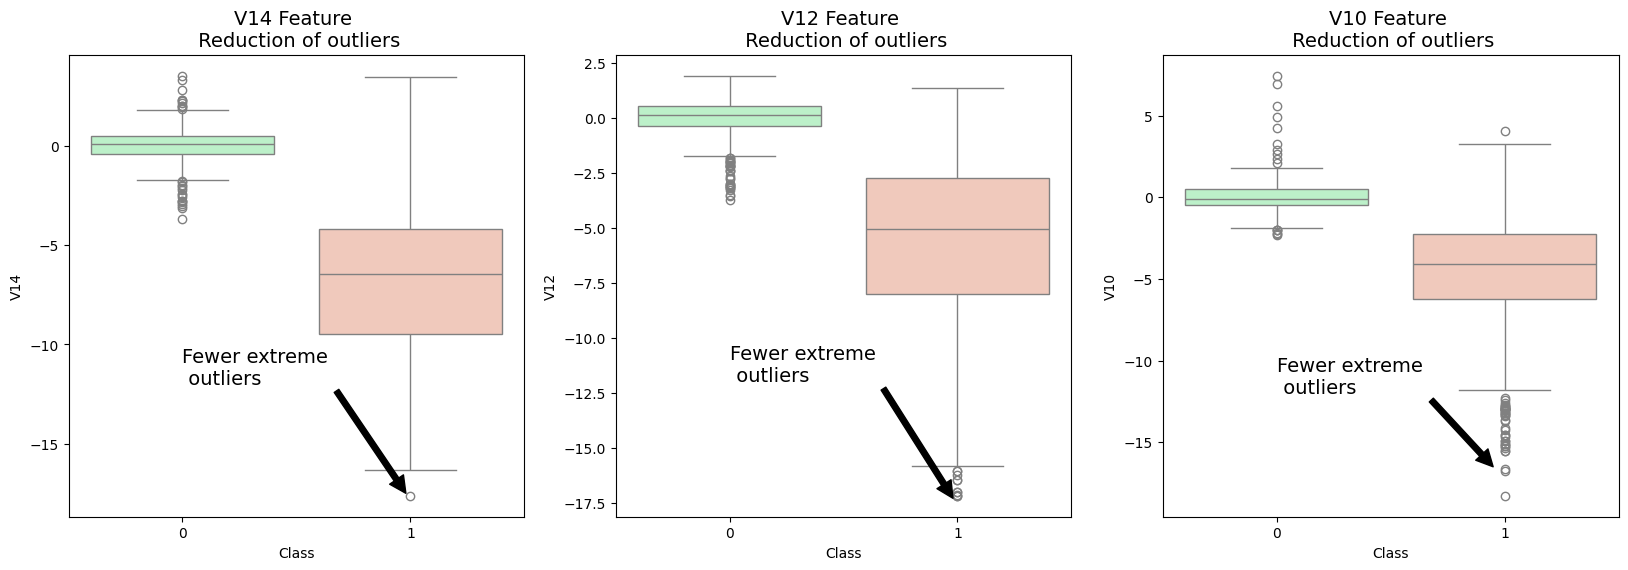

In [15]:
#箱线图可视化展示去掉的异常值
f,(ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,6))

colors = ['#B3F9C5', '#f9c5b3']
#V14特征
sns.boxplot(x="Class", y="V14", data=under_sample_data,ax=ax1, palette=colors)
ax1.set_title("V14 Feature \n Reduction of outliers", fontsize=14)
ax1.annotate('Fewer extreme \n outliers', xy=(0.98, -17.5), xytext=(0, -12),
             arrowprops=dict(facecolor='black'),
             fontsize=14)

#V12特征
sns.boxplot(x="Class", y="V12", data=under_sample_data, ax=ax2, palette=colors)
ax2.set_title("V12 Feature \n Reduction of outliers", fontsize=14)
ax2.annotate('Fewer extreme \n outliers', xy=(0.98, -17.3), xytext=(0, -12),
             arrowprops=dict(facecolor='black'),
             fontsize=14)

#V10特征
sns.boxplot(x="Class", y="V10", data=under_sample_data, ax=ax3, palette=colors)
ax3.set_title("V10 Feature \n Reduction of outliers", fontsize=14)
ax3.annotate('Fewer extreme \n outliers', xy=(0.95, -16.5), xytext=(0, -12),
             arrowprops=dict(facecolor='black'),
             fontsize=14)

plt.show()

C:\Users\cm400\AppData\Local\Temp\ipykernel_16368\1808665487.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Class", y="V4", data=under_sample_data,ax=ax1, palette=colors)
C:\Users\cm400\AppData\Local\Temp\ipykernel_16368\1808665487.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Class", y="V2", data=under_sample_data, ax=ax2, palette=colors)
C:\Users\cm400\AppData\Local\Temp\ipykernel_16368\1808665487.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Class", y="V11", data=under_sample_data, ax=ax3, palette=colors)


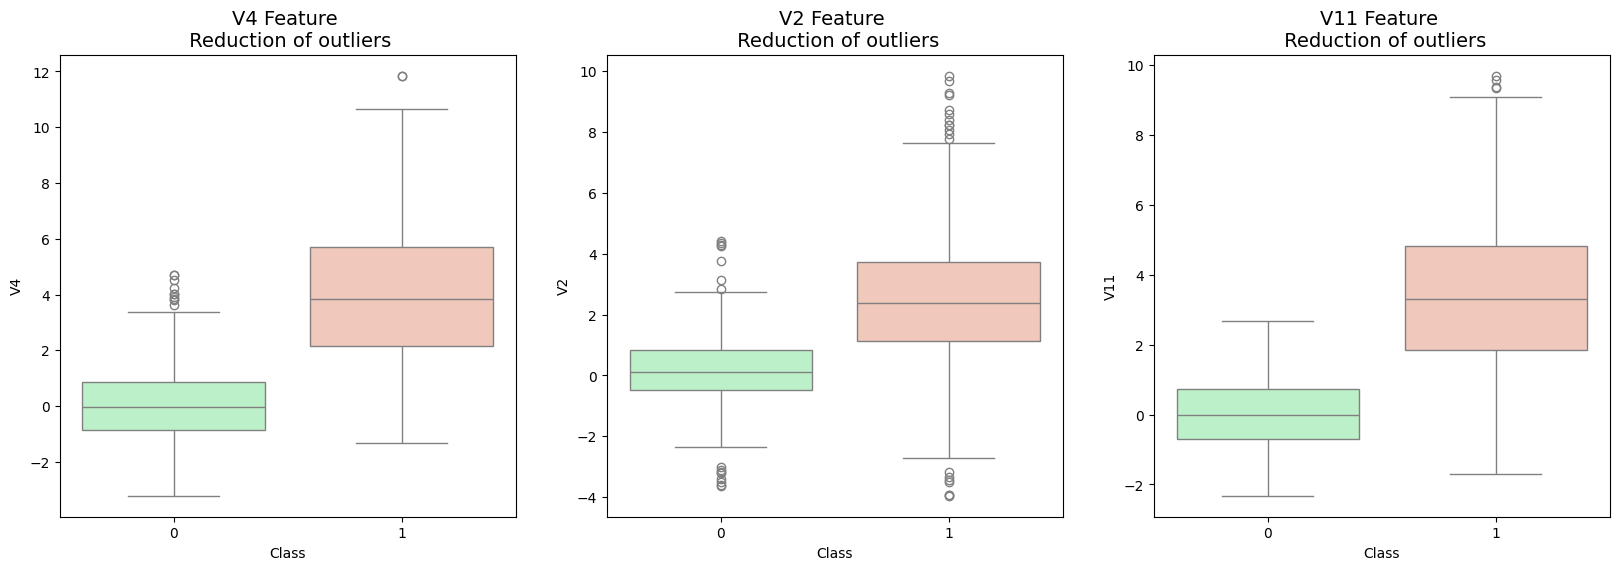

In [16]:
f,(ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,6))

colors = ['#B3F9C5', '#f9c5b3']
#V4特征
sns.boxplot(x="Class", y="V4", data=under_sample_data,ax=ax1, palette=colors)
ax1.set_title("V4 Feature \n Reduction of outliers", fontsize=14)
ax1.annotate('Fewer extreme \n outliers', xy=(0.98, -17.5), xytext=(0, -12),
             arrowprops=dict(facecolor='black'),
             fontsize=14)

#V2特征
sns.boxplot(x="Class", y="V2", data=under_sample_data, ax=ax2, palette=colors)
ax2.set_title("V2 Feature \n Reduction of outliers", fontsize=14)
ax2.annotate('Fewer extreme \n outliers', xy=(0.98, -17.3), xytext=(0, -12),
             arrowprops=dict(facecolor='black'),
             fontsize=14)

#V11特征
sns.boxplot(x="Class", y="V11", data=under_sample_data, ax=ax3, palette=colors)
ax3.set_title("V11 Feature \n Reduction of outliers", fontsize=14)
ax3.annotate('Fewer extreme \n outliers', xy=(0.95, -16.5), xytext=(0, -12),
             arrowprops=dict(facecolor='black'),
             fontsize=14)

plt.show()

### 3.降维和聚类可视化
使用SVD进行降维运算，并聚类

In [17]:
import time
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD

X = under_sample_data.drop('Class', axis=1)
y = under_sample_data['Class']

t0 = time.time()
X_reduced_svd = TruncatedSVD(n_components=2, algorithm='randomized', random_state=42).fit_transform(X.values)
t1 = time.time()
print("Truncated SVD took {:.2} s".format(t1 - t0))

Truncated SVD took 0.13 s


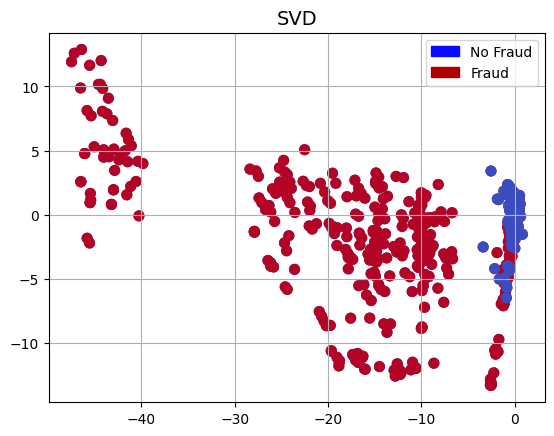

In [18]:
import matplotlib.patches as mpatches

#对降维后的数据进行聚类
blue_patch = mpatches.Patch(color='#0A0AFF', label='No Fraud')
red_patch = mpatches.Patch(color='#AF0000', label='Fraud')

plt.title('Clusters using Dimensionality Reduction', fontsize=14)
plt.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
plt.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
plt.title('SVD', fontsize=14)

plt.grid(True)

plt.legend(handles=[blue_patch, red_patch])

plt.show()

### 4.模型建立

In [19]:
X_train_undersample, X_test_undersample, y_train_undersample, y_test_undersample = train_test_split(X_under_sample,y_under_sample,test_size=0.3,random_state=30)

In [20]:
def show_metrics():
    tp = cm[1,1]
    fn = cm[1,0]
    fp = cm[0,1]
    tn = cm[0,0]
    print('精确率: {:.3f}'.format(tp/(tp+fp)))
    print('召回率: {:.3f}'.format(tp/(tp+fn)))
    print('F1值: {:.3f}'.format(2*(((tp/(tp+fp))*(tp/(tp+fn)))/((tp/(tp+fp))+(tp/(tp+fn))))))

In [21]:
def plot_confusion_matrix(cm, classes,# 混淆矩阵（二维数组）和类别标签
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap) # 绘制热图，最近邻插值
    plt.title(title)
    plt.colorbar() # 颜色条
    tick_marks = np.arange(len(classes)) # 包含类别标签的索引，用于标记刻度
    plt.xticks(tick_marks, classes, rotation=0) 
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2. # 根据阈值将文本设置为白色或黑色
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):# 双重循环遍历混淆矩阵
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#### 逻辑回归处理下采样数据

In [22]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score,f1_score,accuracy_score

def printing_Kfold_scores(x_train_data,y_train_data):# 测试每个参数并输出性能
    # 返回fold迭代器
    fold = KFold(5,shuffle=False) # 使用5折交叉验证
    print(type(fold))

    # 参数列表
    c_param_range = [0.1,1,10,100]
    
    # 生成不同参数的平均召回率的dataframe
    results_table = pd.DataFrame(index = range(len(c_param_range),2), columns = ['C_parameter','Mean recall score']) # 形成df
    results_table['C_parameter'] = c_param_range # c参数列
    

    # k-fold 2个列表:train_indices = indices[0]， test_indices = indices[1]
    j = 0 # 用于记录参数序列值
    for c_param in c_param_range:# 得到每个参数的召回率  
        print('-------------------------------------------')
        print('C parameter: ', c_param)
        print('-------------------------------------------')
        print('')

        recall_accs = []# 召回率列表
        # fold.split(y_train_data) --->生成器 每次随机生成训练集和validation集
        for iteration, indices in enumerate(fold.split(y_train_data),start=1):# 用于交叉验证的每个折叠的索引 循环5次

            # 模型生成
            #L2正则化通过惩罚模型系数的平方和来防止过拟合
            lr = LogisticRegression(C = c_param, penalty = 'l2',solver='liblinear')

            # 使用训练数据来拟合模型。[0]的数据用来训练模型，[1]用来验证
            lr.fit(x_train_data.iloc[indices[0],:],y_train_data.iloc[indices[0],:].values.ravel()) # 提取某列数据并转换成array

            # 数据中的indices[1]去预测
            y_pred_ = lr.predict(x_train_data.iloc[indices[1],:])

            # 计算召回率，并添加到列表中
            recall_acc = recall_score(y_train_data.iloc[indices[1],:],y_pred_)
            recall_accs.append(recall_acc)
            print('Iteration ', iteration,': recall score = ', recall_acc)

        # 一个参数对应的一列平均值是度量标准
        results_table.iloc[j, results_table.columns.get_loc('Mean recall score')] = np.mean(recall_accs)

        j += 1
        print('')
        print('Mean recall score ', np.mean(recall_accs))
        print('')

    # best_c = results_table.loc[results_table['Mean recall score'].idxmax()]['C_parameter']
    best_c=results_table.loc[results_table['Mean recall score'].astype(float).idxmax()]['C_parameter']


    
    # 最后，我们可以检查所选的C参数中哪个是最好的。
    print('*********************************************************************************')
    print('Best model to choose from cross validation is with C parameter = ', best_c)
    print('*********************************************************************************')

    return best_c

In [23]:
best_c = printing_Kfold_scores(X_train_undersample,y_train_undersample) # 传入训练数据

<class 'sklearn.model_selection._split.KFold'>
-------------------------------------------
C parameter:  0.1
-------------------------------------------

Iteration  1 : recall score =  0.9459459459459459
Iteration  2 : recall score =  0.8888888888888888
Iteration  3 : recall score =  0.9333333333333333
Iteration  4 : recall score =  0.8571428571428571
Iteration  5 : recall score =  0.8955223880597015

Mean recall score  0.9041666826741455

-------------------------------------------
C parameter:  1
-------------------------------------------

Iteration  1 : recall score =  0.9459459459459459
Iteration  2 : recall score =  0.8888888888888888
Iteration  3 : recall score =  0.9333333333333333
Iteration  4 : recall score =  0.8571428571428571
Iteration  5 : recall score =  0.9104477611940298

Mean recall score  0.907151757301011

-------------------------------------------
C parameter:  10
-------------------------------------------

Iteration  1 : recall score =  0.9459459459459459
Iterat

精确率: 0.970
召回率: 0.923
F1值: 0.946


C:\Users\cm400\AppData\Local\Temp\ipykernel_16368\1908384779.py:20: UserWarning: Glyph 36923 (\N{CJK UNIFIED IDEOGRAPH-903B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\cm400\AppData\Local\Temp\ipykernel_16368\1908384779.py:20: UserWarning: Glyph 36753 (\N{CJK UNIFIED IDEOGRAPH-8F91}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\cm400\AppData\Local\Temp\ipykernel_16368\1908384779.py:20: UserWarning: Glyph 22238 (\N{CJK UNIFIED IDEOGRAPH-56DE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\cm400\AppData\Local\Temp\ipykernel_16368\1908384779.py:20: UserWarning: Glyph 24402 (\N{CJK UNIFIED IDEOGRAPH-5F52}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\cm400\AppData\Local\Temp\ipykernel_16368\1908384779.py:20: UserWarning: Glyph 28151 (\N{CJK UNIFIED IDEOGRAPH-6DF7}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\cm400\AppData\Local\Temp\ipykernel_16368\1908384779.py:20: UserWarning: Glyph 28102 (\

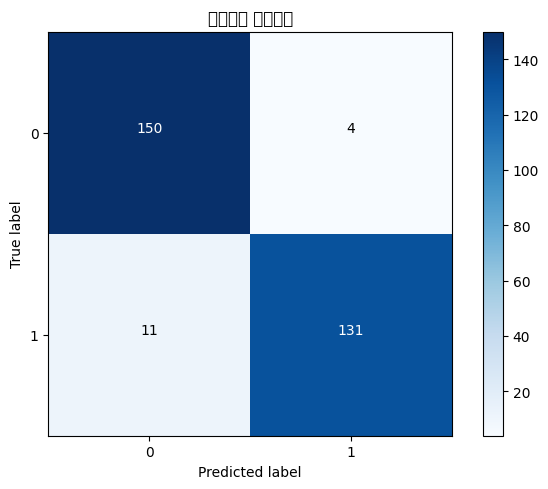

In [24]:
import itertools
from sklearn.metrics import confusion_matrix

lr = LogisticRegression(C = best_c, penalty = 'l2')  # 得到最优参数分类器
lr.fit(X_train_undersample,y_train_undersample.values.ravel()) #模型训练
y_pred_1 = lr.predict(X_test_undersample) # 模型预测

# Compute confusion matrix
cm = confusion_matrix(y_test_undersample,y_pred_1)
show_metrics()
np.set_printoptions(precision=2)

# print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cm
                      , classes=class_names
                      , title='逻辑回归 混淆矩阵')
plt.show()

#### 支持向量机模型

In [25]:
from sklearn import svm

#支持向量机使用网格搜索和交叉验证来寻找最优参数


In [26]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix , precision_recall_curve
from sklearn.model_selection import GridSearchCV
import itertools
#支持向量机使用网格搜索和交叉验证来寻找最优参数

#定义要搜索的超参数网格
param_grid = {  
    'C': [0.1, 1, 10, 100],  
    'gamma': ['scale', 'auto', 0.01, 0.001, 0.0001],  
    'kernel': ['rbf', 'linear']  
}  

# 初始化SVM分类器和网格搜索  
svm = SVC(random_state=42)  
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5, scoring='accuracy')  

# 在训练集上进行网格搜索  
grid_search.fit(X_train, y_train) 

# 使用最佳参数在测试集上进行预测  
best_svm = grid_search.best_estimator_  
y_pred_2 = best_svm.predict(y_train) 

#  model = svm.SVC()
#  model = svm.LinearSVC()


# model.fit(X_resample,y_resample)
#y_pred_2=model.predict(X_test_undersample)
cm = confusion_matrix(y_test_undersample,y_pred_2)
show_metrics()
plt.rcParams['font.sans-serif'] = ['SimHei']

class_names = [0,1]
plot_confusion_matrix(cm, classes = class_names, title = '支持向量机 混淆矩阵')



d:\py\Lib\site-packages\sklearn\utils\validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\py\Lib\site-packages\sklearn\utils\validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


#### 决策树算法处理下采样数据

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer

#决策树使用网格搜索和交叉验证寻找最优参数
def fit_model_k_fold(X, y):
    """ Performs grid search over the 'max_depth' parameter for a 
        decision tree regressor trained on the input data [X, y]. """
    
    # Create cross-validation sets from the training data
    # cv_sets = ShuffleSplit(n_splits = 10, test_size = 0.20, random_state = 0)
    k_fold = KFold(n_splits=5)
    
    #  Create a decision tree clf object
    clf = DecisionTreeClassifier(random_state=80)

    params = {'max_depth':range(1,21),'criterion':np.array(['entropy','gini'])}

    # Transform 'accuracy_score' into a scoring function using 'make_scorer' 
    scoring_fnc = make_scorer(accuracy_score)

    # Create the grid search object
    grid = GridSearchCV(clf, param_grid=params,scoring=scoring_fnc,cv=k_fold)

    # Fit the grid search object to the data to compute the optimal model
    grid = grid.fit(X, y)

    # Return the optimal model after fitting the data
    return grid.best_estimator_

精确率: 0.933
召回率: 0.880
F1值: 0.906


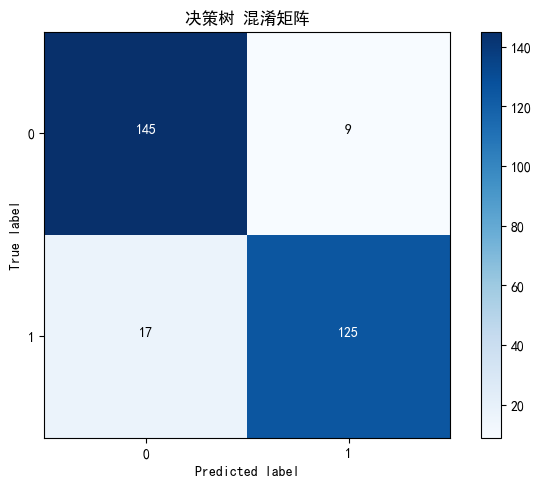

In [ ]:
#预测训练后的决策树模型
model = fit_model_k_fold(X_train_undersample, y_train_undersample)
y_pred_3 = model.predict(X_test_undersample)
cm = confusion_matrix(y_test_undersample,y_pred_3)
show_metrics()
plt.rcParams['font.sans-serif'] = ['SimHei']

class_names = [0,1]
plot_confusion_matrix(cm, classes = class_names, title = '决策树 混淆矩阵')

### 5.三种算法roc曲线绘制对比

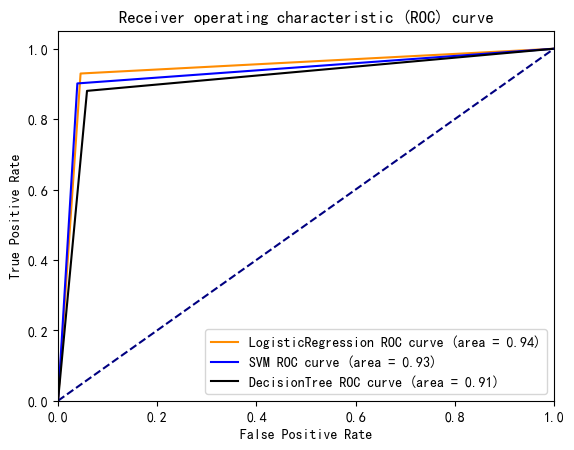

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

#计算ROC值
#计算逻辑回归模型的ROC值
fpr1, tpr1, thresholds1 = roc_curve(y_test_undersample, y_pred_1)
roc_auc1 = roc_auc_score(y_test_undersample, y_pred_1)

#计算支持向量机模型的ROC值
fpr2, tpr2, thresholds2 = roc_curve(y_test_undersample, y_pred_2)
roc_auc2 = roc_auc_score(y_test_undersample, y_pred_2)

#计算决策树模型的ROC值
fpr3, tpr3, thresholds3 = roc_curve(y_test_undersample, y_pred_3)
roc_auc3 = roc_auc_score(y_test_undersample, y_pred_3)

# 绘制ROC曲线
plt.plot(fpr1, tpr1, color='darkorange', label='LogisticRegression ROC curve (area = %0.2f)' % roc_auc1)
plt.plot(fpr2, tpr2, color='blue', label='SVM ROC curve (area = %0.2f)' % roc_auc2)
plt.plot(fpr3, tpr3, color='black', label='DecisionTree ROC curve (area = %0.2f)' % roc_auc3)

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

### 6.逻辑回归处理过采样数据
交叉验证和smote算法同时进行

In [ ]:
# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
#%%
from imblearn.over_sampling import SMOTE 
# 处理不平衡数据
sm = SMOTE(random_state=123)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)
#%%
y_train_sm.info()

<class 'pandas.core.series.Series'>
RangeIndex: 398060 entries, 0 to 398059
Series name: Class
Non-Null Count   Dtype
--------------   -----
398060 non-null  int64
dtypes: int64(1)
memory usage: 3.0 MB


精确率: 0.066
召回率: 0.899
F1值: 0.124


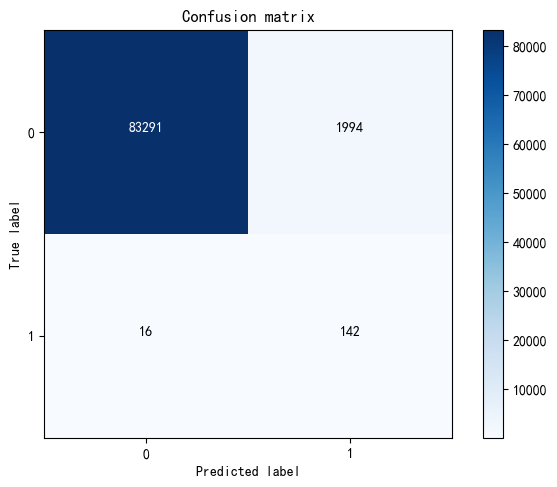

In [ ]:
# 
lr.fit(X_train_sm,y_train_sm.values.ravel()) #模型训练
y_pred_4 = lr.predict(X_test) # 模型预测

# Compute confusion matrix
cm = confusion_matrix(y_test,y_pred_4)
show_metrics()
np.set_printoptions(precision=2)

# print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cm
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

d:\py\Lib\site-packages\sklearn\utils\validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


精确率: 0.119
召回率: 0.854
F1值: 0.209


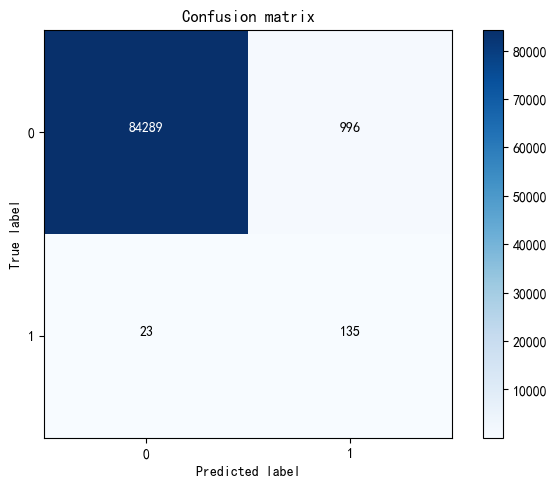

In [ ]:
lr.fit(X_resample,y_resample) #模型训练
y_pred_5 = lr.predict(X_test) # 模型预测

# Compute confusion matrix
cm = confusion_matrix(y_test,y_pred_5)
show_metrics()
np.set_printoptions(precision=2)

# print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cm
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

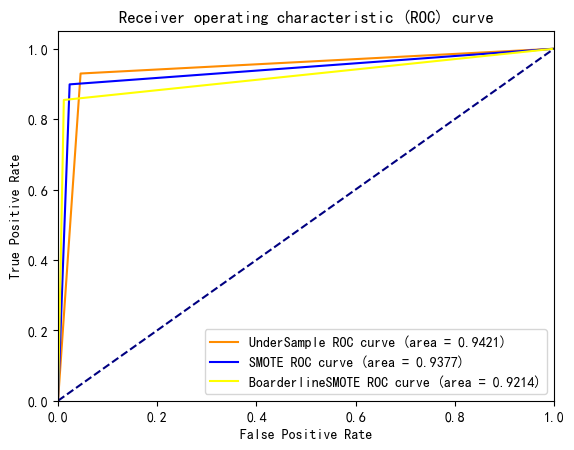

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

#计算ROC值
#计算下采样样本的逻辑回归模型的ROC值
fpr1, tpr1, thresholds1 = roc_curve(y_test_undersample, y_pred_1)
roc_auc1 = roc_auc_score(y_test_undersample, y_pred_1)

#计算SMOTE采样样本的逻辑回归模型的ROC值
fpr4, tpr4, thresholds4 = roc_curve(y_test, y_pred_4)
roc_auc4 = roc_auc_score(y_test, y_pred_4)

#计算boarderline smote采样样本的逻辑回归模型的ROC值
fpr5, tpr5, thresholds5 = roc_curve(y_test, y_pred_5)
roc_auc5 = roc_auc_score(y_test, y_pred_5)

# 绘制ROC曲线
plt.plot(fpr1, tpr1, color='darkorange', label='UnderSample ROC curve (area = %0.4f)' % roc_auc1)
plt.plot(fpr4, tpr4, color='blue', label='SMOTE ROC curve (area = %0.4f)' % roc_auc4)
plt.plot(fpr5, tpr5, color='yellow', label='BoarderlineSMOTE ROC curve (area = %0.4f)' % roc_auc5)

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()